#### Recommendation System using surprise

##### Importing all libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import Reader, Dataset, SVD
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

In [11]:
train=pd.read_csv("train_MaefO4x/train.csv")
jokes=pd.read_csv("train_MaefO4x/jokes.csv")
test=pd.read_csv("test_MElQnvy/test.csv")

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092059 entries, 0 to 1092058
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   id       1092059 non-null  object 
 1   user_id  1092059 non-null  int64  
 2   joke_id  1092059 non-null  int64  
 3   Rating   1092059 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.3+ MB


In [54]:
jokes

,joke_id,joke_text
0,1,Q. What's O. J. Simpson's web address? A. Slas...
1,2,How many feminists does it take to screw in a ...
2,3,Q. Did you hear about the dyslexic devil worsh...
3,4,They asked the Japanese visitor if they have e...
4,5,Q: What did the blind person say when given so...
...,...,...
134,135,"A blonde, brunette, and a red head are all lin..."
135,136,America: 8:00 - Welcome to work! 12:00 - Lunch...
136,137,It was the day of the big sale. Rumors of the ...
137,138,"Recently a teacher, a garbage collector, and a..."


In [55]:
train.shape,test.shape

((1092059, 4), (537880, 4))

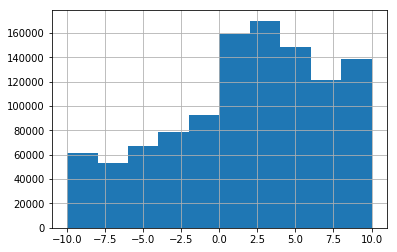

In [13]:
train['Rating'].hist()

In [5]:
train['Count']=train.groupby('joke_id')['Rating'].transform('nunique')

In [9]:
train

,id,user_id,joke_id,Rating,Count
0,31030_110,31030,110,2.750,639
1,16144_109,16144,109,5.094,640
2,23098_6,23098,6,-6.438,641
3,14273_86,14273,86,4.406,635
4,18419_134,18419,134,9.375,635
...,...,...,...,...,...
1092054,9517_132,9517,132,3.156,639
1092055,27767_118,27767,118,-1.594,637
1092056,10580_81,10580,81,2.000,638
1092057,31007_119,31007,119,8.906,641


In [5]:
train.columns

Index(['id', 'user_id', 'joke_id', 'Rating'], dtype='object')

In [20]:
reader = Reader(rating_scale=(-10, 10))
data = Dataset.load_from_df(train[['user_id', 'joke_id', 'Rating']], reader)
train_set, test_set = train_test_split(data, test_size=0.2)

##### Grid search on algortihm to identify optimal parameters

In [29]:
pg_SVD = {'n_epochs': [10, 25, 50], 'lr_all': [0.001, 0.005, 0.01], 
              'reg_all': [0.1, 0.4, 0.08]}
gs_SVD = GridSearchCV(SVD, pg_SVD, measures = ['rmse'], cv = 3)
gs_SVD.fit(data)

In [30]:
print(gs_SVD.best_score['rmse']),print(gs_SVD.best_params['rmse'])

4.082331322941369
{'n_epochs': 25, 'lr_all': 0.001, 'reg_all': 0.1}


(None, None)

In [23]:
#params={'n_epochs': 25, 'lr_all': 0.001, 'reg_all': 0.1}
svd=SVD(n_epochs=25,lr_all=0.001,reg_all=0.1,random_state=123)
svd.fit(train_set)

In [24]:
predictions=svd.test(test_set)

In [25]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 4.0460


4.04596759933299

In [48]:
train

,id,user_id,joke_id,Rating
0,31030_110,31030,110,2.750
1,16144_109,16144,109,5.094
2,23098_6,23098,6,-6.438
3,14273_86,14273,86,4.406
4,18419_134,18419,134,9.375
...,...,...,...,...
1092054,9517_132,9517,132,3.156
1092055,27767_118,27767,118,-1.594
1092056,10580_81,10580,81,2.000
1092057,31007_119,31007,119,8.906


##### Prediction on test data

In [51]:
test_prediction=[(test.iloc[i,0],test.iloc[i,1],test.iloc[i,2],
                  svd.predict(test.iloc[i,1],test.iloc[i,2]).est) for i in range(test.shape[0]) ]

In [52]:
TestDF=pd.DataFrame(test_prediction,columns=['id','user_id','joke_id','Rating'])

In [56]:
TestDF.to_csv("test_prediction.csv",index=False,header=TestDF.columns)

In [57]:
output=cross_validate(svd,data)

In [58]:
output

{'test_rmse': array([4.03403953, 4.05519826, 4.05025718, 4.03644837, 4.03664172]),
 'test_mae': array([3.04893923, 3.05886954, 3.05964772, 3.04606559, 3.04618577]),
 'fit_time': (62.6945526599884,
  62.98267459869385,
  63.14225101470947,
  64.15850329399109,
  63.346858978271484),
 'test_time': (2.320797920227051,
  2.3148372173309326,
  2.308819532394409,
  2.305837869644165,
  1.5099537372589111)}

In [ ]:
# benchmark=[]
# for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
#     # Perform cross validation
#     results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
#     # Get results & append algorithm name
#     tmp = pd.DataFrame.from_dict(results).mean(axis=0)
#     tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
#     benchmark.append(tmp)